## University of California - Irvine
### Bank Marketing Data Set

### From UCI:
**Input variables:**

**bank client data:**
- 1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

**related with the last contact of the current campaign:**
- 8 - contact: contact communication type (categorical: 'cellular','telephone') 
- 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
- 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 - previous: number of contacts performed before this campaign and for this client (numeric)
- 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**social and economic context attributes**
- 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
- 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**
- 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import display
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

import seaborn as sns
sns.set()

# Pre Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve, GridSearchCV

# Over Sampling
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN

# Classic Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import sklearn.metrics as metrics


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df_original=pd.read_csv("c:/data/bank-additional-full.csv",sep=';')
df_original=df_original.drop(['duration'],axis=1) # Per instructions from UC Irvine 
df_original.loc[df_original.pdays == 999, 'pdays'] = np.nan # 999 = No data from UCI.
df = df_original.copy()

print(df.shape)
display(df.head())

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Extend the DataFrame describe() method to show nunique, null counts and column type. 

In [3]:
def extended_describe(df):
    de = df.describe()

    nu = pd.DataFrame(df.nunique())
    nu.columns = ['nunique']
    nu = nu.transpose()

    nan = pd.DataFrame(df.isnull().sum(axis=0))
    nan.columns = ['nan']
    nan = nan.transpose()

    de = de.append([nu, nan], sort=False).transpose()
    de['categorical'] = de['count'].isnull()
    de.index.name = 'column'
    return de

In [4]:
de = extended_describe(df)
de

,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000,78.0,0.0,False
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000,42.0,0.0,False
pdays,1515.0,6.014521,3.824906,0.000,3.000,6.000,7.000,27.000,26.0,39673.0,False
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000,8.0,0.0,False
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400,10.0,0.0,False
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767,26.0,0.0,False
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900,26.0,0.0,False
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045,316.0,0.0,False
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100,11.0,0.0,False


In [5]:
numeric_columns = list(de.loc[de.categorical == False].reset_index()['column'])
categorical_columns = list(de.loc[de.categorical == True].reset_index()['column'])
# print(numeric_columns, categorical_columns)

## Outliers 
Looking at the 25th percentile and the min, as well as the 75th percentile and the max, the data does not have any extremes that we need to deal with. 
  
## Null Values 
Only pdays (days since last phone contact) has null values.  In the original dataset, this was set to 999, but was changed to nan after load.  The far majority of the values are null.   
  
### pdays 
The output variable is the column **y** (did the prospect sign up for a term deposit).  So, let's see if pdays has a significant correlation of to the output variable. 

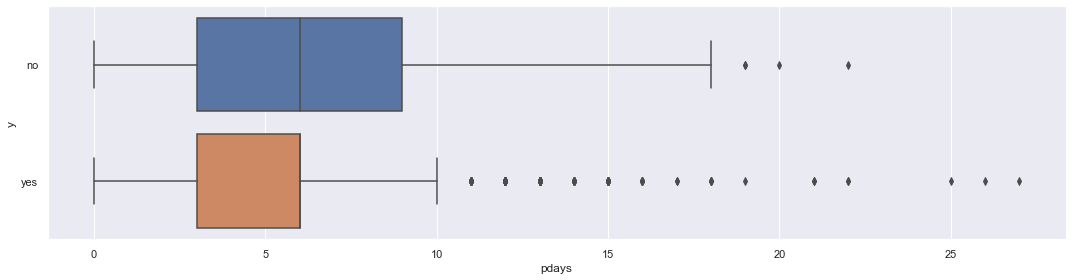

In [6]:
f = plt.figure(figsize=(15, 4))
sns.boxplot(x=df['pdays'], y=df['y'])
f.tight_layout()
plt.show()

The positive outcomes have a shorter **pdays** value.  So, let's keep the feature, but convert it to a categorical column and drop the numeric column. 

In [7]:
pdays_columns = ['no_contact', 'contact_0_5', 'contact_5_10', 'contact_10_15', 'contact_20']

df[pdays_columns[0]] = 0
df[pdays_columns[0]][df.pdays.isnull()] = 1

df[pdays_columns[1]] = 0
df[pdays_columns[1]][df.pdays <= 5] = 1

df[pdays_columns[2]] = 0
df[pdays_columns[2]][(df.pdays > 5) & (df.pdays <= 10)] = 1

df[pdays_columns[3]] = 0
df[pdays_columns[3]][(df.pdays > 15) & (df.pdays <= 20)] = 1

df[pdays_columns[4]] = 0
df[pdays_columns[4]][df.pdays > 20] = 1
                                     
df.drop('pdays', axis=1, inplace=True);
numeric_columns.remove('pdays')
categorical_columns = categorical_columns + pdays_columns

### Now let's look at the value counts for the categorical columns (sans dummies we just built). 

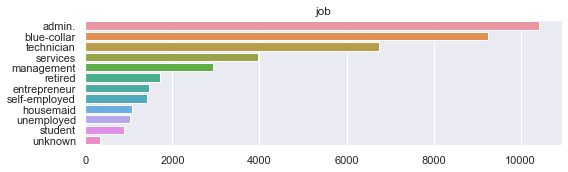

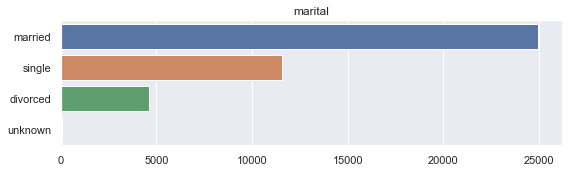

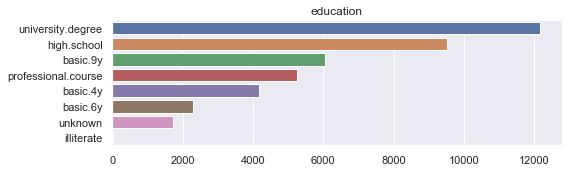

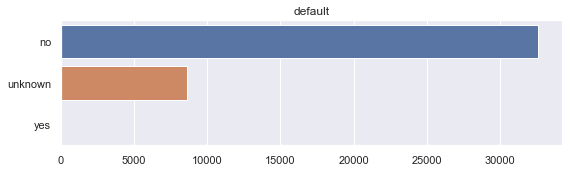

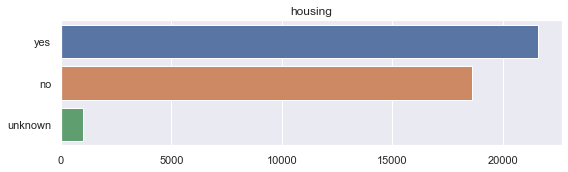

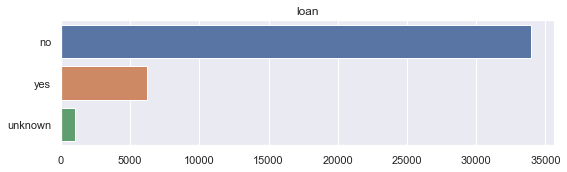

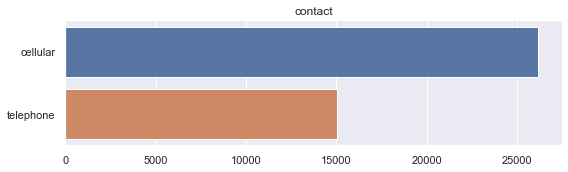

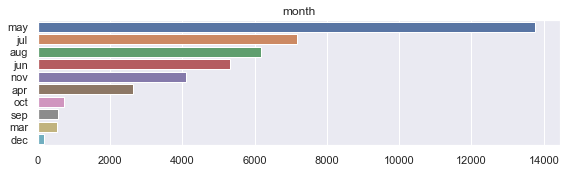

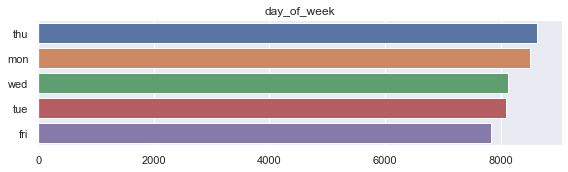

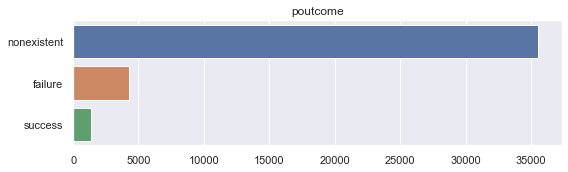

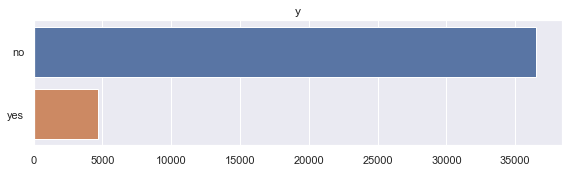

In [8]:
categorical_columns_sans_pdays = [c for c in categorical_columns if c not in pdays_columns]
for col in categorical_columns_sans_pdays:
    plt.figure(figsize=(8,2.5))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()   

### For numeric features, let's look at histograms. 

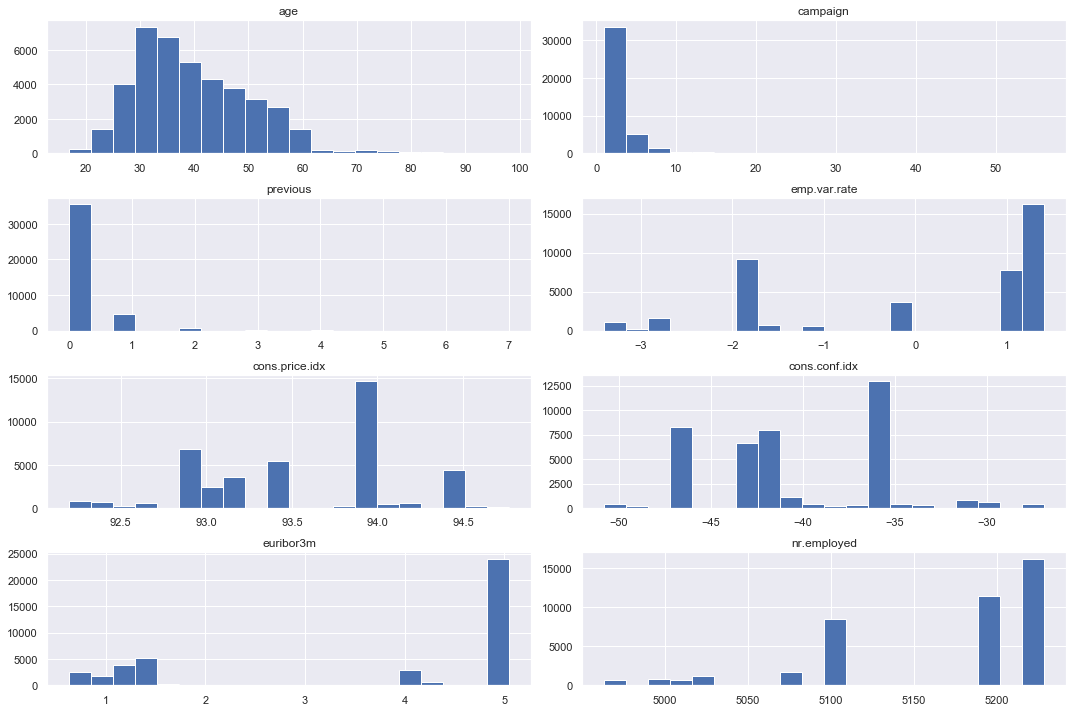

In [9]:
i = 0
j = 0
row_count = len(numeric_columns) // 2
f = plt.figure(figsize=(15, 10))
gs = f.add_gridspec(row_count, 2)

for col in numeric_columns:
    ax = f.add_subplot(gs[i, j])
    ax.hist(df[col], bins=20)
    ax.set_title(col)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1

f.tight_layout()
plt.show()

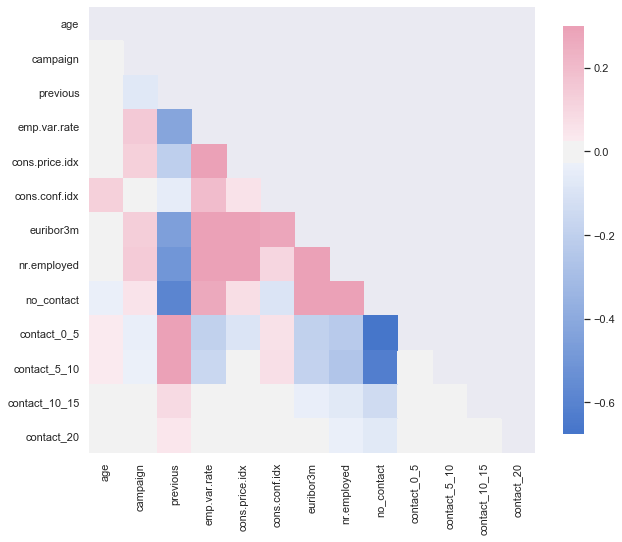

In [10]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(255, 0, as_cmap=True)

f = plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, cbar_kws={"shrink": .75})

## Imbalanced Data

#### Only 11% of the data produced a positive outcome

'YES' = Success marketing to sign up an account.

In [11]:
print("Percent of rows labeled as \'YES\' = {0:.0%}".format(sum(df.y=='yes')/len(df)))
print("Percent of rows labeled as \'NO\' = {0:.0%}".format(sum(df.y=='no')/len(df)))

Percent of rows labeled as 'YES' = 11%
Percent of rows labeled as 'NO' = 89%


# Approach

### Classifiers

We will be looking at 5 different classifiers
- Logistic Regression
- Support Vector Machine (SVM)
- Random Forest
- Gradient Boosting
- Simple Neural Network


### Preprocessing Features:

Random Forest and Gradient Boosting are based on decision trees.  Logistic, SVM and NN are based on a linear approach.  
Because of this, we will preprocess the dataset in two different ways.  The decision tree models do not need any prep other than oversampling, whereas the linear models will need hot-one encoding (categorical features) and some type of standardization (numeric features).

#### Oversampling
Since EDA did not show any significant outliers and the small number of null values were already taken care of, the most import general preprocessing step is to compensate for the imbalanced data.  

We will use SMOTE for this, but only after the data is split into training and testing so.  But since we will also be using cross validation folds, we will need to make sure the oversampling is not done on the validation set in each fold.  

Since SMOTE uses KNN, which needs to have only numeric features.  Se we need to use SMOTENC which can accept both numeric and catagorical features.

### Steps
- Split into train and test
- Use K fold cross validation
- Use SMOTE on the training data for each for the K folds
- Clone test and the K folds to allow for different preprocessing
- Apply standardization and dummies to the data copies used for the linear models


In [12]:
df_copy = df.copy()
df_copy.y = df_copy.y.map({'yes':1, 'no':0}) # Clean up output feature while we are here

train, test = train_test_split(df_copy, train_size=.8, random_state=42)

folds = {}
i = 0

kf = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf.split(train):
    
    #KFold only returns the indexes of the rows chosen, so we need to use these indexes to select the rows
    t = train.iloc[train_index].copy()
    v = train.iloc[test_index].copy()
    
    #Seperate features from label for both train and validation
    X_t = t.drop(['y'], axis=1)
    y_t = t['y']
    X_v = v.drop(['y'], axis=1)
    y_v = v['y']

    #We can't use our categorical_columns variable since we just removed the 'y' column.
    #So we need to find the columns in X_t
    X_t_all_columns = X_t.columns
    X_t_numeric_columns = X_t._get_numeric_data().columns
    X_t_categorical_columns = X_t.columns.get_indexer(list(set(X_t_all_columns) - set(X_t_numeric_columns)))
    
    # Oversample
    sm = SMOTENC(X_t_categorical_columns, random_state=42)
    X_t, y_t = sm.fit_resample(X_t, y_t)
    print("Fold {}: Percent of rows labeled as \'NO\' = {:.0%}".format(i, y_t.sum()/len(y_t)))

    # Store folds into a dictionary of tuples
    folds[i] = {'train':(X_t, y_t), 'val':(X_v, y_v)}
    i+=1
    
# Clone the folds so we can do different preprocessing on these datasets    
decision_tree_folds = folds
linear_folds = folds.copy()

Fold 0: Percent of rows labeled as 'NO' = 50%
Fold 1: Percent of rows labeled as 'NO' = 50%
Fold 2: Percent of rows labeled as 'NO' = 50%
Fold 3: Percent of rows labeled as 'NO' = 50%
Fold 4: Percent of rows labeled as 'NO' = 50%


In [13]:
def getScaledDataFrame(df):
    mms = MinMaxScaler()
    mms.fit(df)

    result = pd.DataFrame(mms.transform(df))
    result.columns = df.columns
    result.index = df.index
    return result


#### Preprocess Full Training Dataset

In [14]:
decision_tree_train = train.copy()
decision_tree_train_X = decision_tree_train.drop(['y'], axis=1)
decision_tree_train_y = decision_tree_train['y']

linear_train = train.copy()
linear_train_X = linear_train.drop(['y'], axis=1)
linear_train_X = pd.get_dummies(linear_train_X, drop_first=True)
linear_train_X = getScaledDataFrame(linear_train_X)
linear_train_y = linear_train['y']

#### Preprocess Folds for Linear Models

In [15]:
linear_train = train.copy()


for i, data in linear_folds.items():
    X_t, y_t = data['train']
    X_t = pd.get_dummies(X_t, drop_first=True)
    X_t = getScaledDataFrame(X_t)
    data['train'] = (X_t, y_t)
    
    X_t, y_t = data['val']
    X_t = pd.get_dummies(X_t, drop_first=True)
    X_t = getScaledDataFrame(X_t)
    data['val'] = (X_t, y_t)

linear_folds[0]['train'][0].head()    

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_contact,contact_0_5,contact_5_10,contact_10_15,contact_20,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0.506173,0.000000,0.0,0.479167,0.778644,0.556485,0.056676,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.160494,0.119048,0.0,1.000000,0.669135,0.338912,0.980957,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.296296,0.000000,0.0,0.937500,0.698753,0.602510,0.958059,0.859735,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.358025,0.190476,0.0,1.000000,0.882307,0.376569,0.980957,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.308642,0.261905,0.0,1.000000,0.669135,0.338912,0.981183,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [16]:
def printGridSearchCVResults(clf):
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
 

In [17]:
def runGridSearchCV(clf, grid_values, X, y):
    gs = GridSearchCV(clf, grid_values)
    gs.fit(X, y)
    printGridSearchCVResults(gs)

### Lets find the Best Hyperparameters for our Models (sans nn)

Logistic Regression

In [18]:
logit = LogisticRegression(random_state = 42, solver='saga')
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
runGridSearchCV(logit, grid_values, linear_train_X, linear_train_y)

Best parameters set found on development set:

{'C': 0.1, 'penalty': 'l1'}

Grid scores on development set:

0.888 (+/-0.000) for {'C': 0.001, 'penalty': 'l1'}
0.888 (+/-0.000) for {'C': 0.001, 'penalty': 'l2'}
0.898 (+/-0.002) for {'C': 0.01, 'penalty': 'l1'}
0.900 (+/-0.002) for {'C': 0.01, 'penalty': 'l2'}
0.901 (+/-0.004) for {'C': 0.1, 'penalty': 'l1'}
0.900 (+/-0.005) for {'C': 0.1, 'penalty': 'l2'}
0.901 (+/-0.005) for {'C': 1, 'penalty': 'l1'}
0.901 (+/-0.005) for {'C': 1, 'penalty': 'l2'}
0.900 (+/-0.004) for {'C': 10, 'penalty': 'l1'}
0.900 (+/-0.005) for {'C': 10, 'penalty': 'l2'}
0.900 (+/-0.005) for {'C': 100, 'penalty': 'l1'}
0.900 (+/-0.005) for {'C': 100, 'penalty': 'l2'}
0.900 (+/-0.005) for {'C': 1000, 'penalty': 'l1'}
0.900 (+/-0.005) for {'C': 1000, 'penalty': 'l2'}


Support Vector Machine (SVM)

In [ ]:
sv = svm.SVC(random_state = 42, decision_function_shape='ovo')
grid_values = {'C': [1, 10, 100],  
               'gamma': [0.1, 0.01, 0.001], 
               'kernel': ['rbf', 'linear']}  
runGridSearchCV(sv, grid_values, linear_train_X, linear_train_y)

Random Forest

In [19]:
rf =  ()
grid_values = {'bootstrap': [True],
               'max_depth': [80, 90, 100, 110],
               'max_features': [2, 3],
               'min_samples_leaf': [3, 4, 5],
               'min_samples_split': [8, 10, 12],
               'n_estimators': [100, 200, 300, 1000]}  
runGridSearchCV(rf, grid_values, decision_tree_train_X, decision_tree_train_y)

ValueError: could not convert string to float: 'blue-collar'

Gradient Boosting

In [20]:
gb = GradientBoostingClassifier()
grid_values = {"loss":["deviance"],
               "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
               "min_samples_split": np.linspace(0.1, 0.5, 12),
               "min_samples_leaf": np.linspace(0.1, 0.5, 12),
               "max_depth":[3,5,8],
               "max_features":["log2","sqrt"],
               "criterion": ["friedman_mse",  "mae"],
               "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
               "n_estimators":[10]}  
runGridSearchCV(gb, grid_values, decision_tree_train_X, decision_tree_train_y)

KeyboardInterrupt: 

Simple Neural Network (Multi-layer Preceptron)

In [21]:
mlp = MLPClassifier(random_state=42)
grid_values = {'activation':['logistic','relu'],'solver': ['lbfgs','adam','sgd'],
               'alpha':10.0 ** -np.arange(1,4),
               'hidden_layer_sizes':[(20),(4),(10),(14,2),(4,1),(10,5),(11,3)]}  
runGridSearchCV(mlp, grid_values, linear_train_X, linear_train_y)

Best parameters set found on development set:

{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 10, 'solver': 'adam'}

Grid scores on development set:

0.896 (+/-0.003) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'adam'}
0.898 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'sgd'}
0.900 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'lbfgs'}
0.901 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'adam'}
0.898 (+/-0.001) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'sgd'}
0.898 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 10, 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 10, 'sol